In [43]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product,chain              # Cartesian product for iterators

In [12]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 
import pickle
import random

In [32]:
class GridWorld:
    """
    Basic grid world MDP from Sutton and Barto book.

    Args:
        size: The width and height of the world as integer.

    Attributes:
        n_states: The number of states of this MDP.
        n_actions: The number of actions of this MDP.
        p_transition: The transition probabilities as table. The entry
            `p_transition[from, to, a]` contains the probability of
            transitioning from state `from` to state `to` via action `a`.
        size: The width and height of the world.
        actions: The actions of this world as paris, indicating the
            direction in terms of coordinates.
    """

    def __init__(self, size):
        self.size = size

        self.actions = [(1, 0), (-1, 0), (0, 1), (0, -1)]

        self.n_states = size**2
        self.n_actions = len(self.actions)

        self.p_transition = self._transition_prob_table()

    def state_index_to_point(self, state):
        """
        Convert a state index to the coordinate representing it.

        Args:
            state: Integer representing the state.

        Returns:
            The coordinate as tuple of integers representing the same state
            as the index.
        """
        return state % self.size, state // self.size

    def state_point_to_index(self, state):
        """
        Convert a state coordinate to the index representing it.

        Note:
            Does not check if coordinates lie outside of the world.

        Args:
            state: Tuple of integers representing the state.

        Returns:
            The index as integer representing the same state as the given
            coordinate.
        """
        return state[1] * self.size + state[0]

    def state_point_to_index_clipped(self, state):
        """
        Convert a state coordinate to the index representing it, while also
        handling coordinates that would lie outside of this world.

        Coordinates that are outside of the world will be clipped to the
        world, i.e. projected onto to the nearest coordinate that lies
        inside this world.

        Useful for handling transitions that could go over an edge.

        Args:
            state: The tuple of integers representing the state.

        Returns:
            The index as integer representing the same state as the given
            coordinate if the coordinate lies inside this world, or the
            index to the closest state that lies inside the world.
        """
        s = (max(0, min(self.size - 1, state[0])), max(0, min(self.size - 1, state[1])))
        return self.state_point_to_index(s)

    def state_index_transition(self, s, a):
        """
        Perform action `a` at state `s` and return the intended next state.

        Does not take into account the transition probabilities. Instead it
        just returns the intended outcome of the given action taken at the
        given state, i.e. the outcome in case the action succeeds.

        Args:
            s: The state at which the action should be taken.
            a: The action that should be taken.

        Returns:
            The next state as implied by the given action and state.
        """
        s = self.state_index_to_point(s)
        s = s[0] + self.actions[a][0], s[1] + self.actions[a][1]
        return self.state_point_to_index_clipped(s)

    def _transition_prob_table(self):
        """
        Builds the internal probability transition table.
        """
        table = np.zeros(shape=(self.n_states, self.n_states, self.n_actions))

        s1, s2, a = range(self.n_states), range(self.n_states), range(self.n_actions)
        for s_from, s_to, a in product(s1, s2, a):
            table[s_from, s_to, a] = self._transition_prob(s_from, s_to, a)

        return table

    def _transition_prob(self, s_from, s_to, a):
        """
        Compute the transition probability for a single transition.
        """
        fx, fy = self.state_index_to_point(s_from)
        tx, ty = self.state_index_to_point(s_to)
        ax, ay = self.actions[a]

        # deterministic transition defined by action
        if fx + ax == tx and fy + ay == ty:
            return 1.0

        # we can stay at the same state if we would move over an edge
        if fx == tx and fy == ty:
            if not 0 <= fx + ax < self.size or not 0 <= fy + ay < self.size:
                return 1.0

        # otherwise this transition is impossible
        return 0.0

    def __repr__(self):
        return "GridWorld(size={})".format(self.size)

In [33]:
class Trajectory:
    """
    A trajectory consisting of states, corresponding actions, and outcomes.
    """
    def __init__(self, transitions):
        self._t = transitions

    def transitions(self):
        """
        `(state_from, action, state_to)`.
        """
        return self._t

    def states(self):
        """
        The states visited in this trajectory.
        """
        return map(lambda x: x[0], chain(self._t, [(self._t[-1][2], 0, 0)]))

    def __repr__(self):
        return "Trajectory({})".format(repr(self._t))

    def __str__(self):
        return "{}".format(self._t)


def generate_trajectory(world, policy, start, final):
    """
    Generate a single trajectory.

    Args:
        world: The world for which the trajectory should be generated.
        policy: A function (state: Integer) -> (action: Integer) mapping a
            state to an action, specifying which action to take in which
            state. This function may return different actions for multiple
            invokations with the same state, i.e. it may make a
            probabilistic decision and will be invoked anew every time a
            (new or old) state is visited (again).
        start: The starting state (as Integer index).
        final: A collection of terminal states. If a trajectory reaches a
            terminal state, generation is complete and the trajectory is
            returned.

    Returns:
        A generated Trajectory instance adhering to the given arguments.
    """

    state = start

    trajectory = []
    while state not in final:
        action = policy(state)

        next_s = range(world.n_states)
        next_p = world.p_transition[state, :, action]

        next_state = np.random.choice(next_s, p=next_p)

        trajectory += [(state, action, next_state)]
        state = next_state

    return Trajectory(trajectory)

    
def generate_trajectories(n, world, policy, start, final):
    """
    Generate multiple trajectories.

    Args:
        n: The number of trajectories to generate.
        world: The world for which the trajectories should be generated.
        policy: A function `(state: Integer) -> action: Integer` mapping a
            state to an action, specifying which action to take in which
            state. This function may return different actions for multiple
            invokations with the same state, i.e. it may make a
            probabilistic decision and will be invoked anew every time a
            (new or old) state is visited (again).
        start: The starting state (as Integer index), a list of starting
            states (with uniform probability), or a list of starting state
            probabilities, mapping each state to a probability. Iff the
            length of the provided list is equal to the number of states, it
            is assumed to be a probability distribution over all states.
            Otherwise it is assumed to be a list containing all starting
            state indices, an individual state is then chosen uniformly.
        final: A collection of terminal states. If a trajectory reaches a
            terminal state, generation is complete and the trajectory is
            complete.

    Returns:
        A generator expression generating `n` `Trajectory` instances
        adhering to the given arguments.
    """
    start_states = np.atleast_1d(start)

    def _generate_one():
        if len(start_states) == world.n_states:
            s = np.random.choice(range(world.n_states), p=start_states)
        else:
            s = np.random.choice(start_states)

        return generate_trajectory(world, policy, s, final)

    return (_generate_one() for _ in range(n))


def policy_adapter(policy):
    """
    A policy adapter for deterministic policies.

    Adapts a deterministic policy given as array or map
    `policy[state] -> action` for the trajectory-generation functions.

    Args:
        policy: The policy as map/array
            `policy[state: Integer] -> action: Integer`
            representing the policy function p(state).

    Returns:
        A function `(state: Integer) -> action: Integer` acting out the
        given policy.
    """
    return lambda state: policy[state]


def stochastic_policy_adapter(policy):
    """
    A policy adapter for stochastic policies.

    Adapts a stochastic policy given as array or map
    `policy[state, action] -> probability` for the trajectory-generation
    functions.

    Args:
        policy: The stochastic policy as map/array
            `policy[state: Integer, action: Integer] -> probability`
            representing the probability distribution p(action | state) of
            an action given a state.

    Returns:
        A function `(state: Integer) -> action: Integer` acting out the
        given policy, choosing an action randomly based on the distribution
        defined by the given policy.
    """
    return lambda state: np.random.choice([*range(policy.shape[1])], p=policy[state, :])

In [119]:
def value_iteration(world, p, reward, discount, eps=1e-3):
    """
    Basic value-iteration algorithm to solve the given MDP.

    Args:
        p: The transition probabilities of the MDP as table
            `[from: Integer, to: Integer, action: Integer] -> probability: Float`
            specifying the probability of a transition from state `from` to
            state `to` via action `action` to succeed.
        reward: The reward signal per state as table
            `[state: Integer] -> reward: Float`.
        discount: The discount (gamma) applied during value-iteration.
        eps: The threshold to be used as convergence criterion. Convergence
            is assumed if the value-function changes less than the threshold
            on all states in a single iteration.

    Returns:
        The value function as table `[state: Integer] -> value: Float`.
    """
    n_states, _, n_actions = p.shape
    v = np.zeros(n_states)

    # Setup transition probability matrices for easy use with numpy.
    #
    # This is an array of matrices, one matrix per action. Multiplying
    # state-values v(s) with one of these matrices P_a for action a represents
    # the equation
    #     P_a * [ v(s_i) ]_i^T = [ sum_k p(s_k | s_j, a) * v(s_K) ]_j^T
    p = [np.matrix(p[:, :, a]) for a in range(n_actions)]

    delta = np.inf
    while delta > eps:      # iterate until convergence
        v_old = v

        # compute state-action values (note: we actually have Q[a, s] here)
        q = discount * np.array([p[a] @ v for a in range(n_actions)])

        # compute state values
        v = reward + np.max(q, axis=0)[0]

        # compute maximum delta
        delta = np.max(np.abs(v_old - v))
        
        
    policy = np.array([
        np.argmax([v[world.state_index_transition(s, a)] for a in range(world.n_actions)])
        for s in range(world.n_states)
    ])

    return v, policy


In [120]:
# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../src/irl_maxent')))

import solver as S                          # MDP solver (value-iteration)
import plot as P                            # helper-functions for plotting

In [114]:
%matplotlib widget
plt.rcParams['figure.figsize'] = [9, 5]     # set default figure size
style = {                                   # global style for plots
    'border': {'color': 'red', 'linewidth': 0.5},
}

In [36]:
def state_features(world):
    
    return np.identity(world.n_states)

In [37]:
def feature_expectation_from_trajectories(features, trajectories):
    n_states, n_features = features.shape

    fe = np.zeros(n_features)

    for t in trajectories:                  # for each trajectory
        for s in t.states():                # for each state in trajectory
            fe += features[s, :]            # sum-up features

    return fe / len(trajectories)           # average over trajectories

In [38]:
def setup_mdp():
    # create our world
    world = GridWorld(size=5)

    # set up the reward function
    reward = np.zeros(world.n_states)
    reward[-1] = 1.0
    reward[8] = 0.65

    # set up terminal states
    terminal = [24]

    return world, reward, terminal

# set-up the GridWorld Markov Decision Process
world, reward, terminal = setup_mdp()

In [121]:
def generate_expert_trajectories(world, reward, terminal):
    n_trajectories = 200         # the number of "expert" trajectories
    discount = 0.9               # discount for constructing an "expert" policy
    weighting = lambda x: x**50  # down-weight less optimal actions
    start = [0]                  # starting states for the expert

    # compute the value-function
    value, policy = value_iteration(world, world.p_transition, reward, discount)
    
    # create our stochastic policy using the value function
    # policy = S.stochastic_policy_from_value(world, value, w=weighting)
    
    # a function that executes our stochastic policy by choosing actions according to it
    policy_exec = policy_adapter(policy)
    
    # generate trajectories
    tjs = list(generate_trajectories(n_trajectories, world, policy_exec, start, terminal))
    
    return tjs, policy, value

# generate some "expert" trajectories (and its policy for visualization)
trajectories, expert_policy, expert_value = generate_expert_trajectories(world, reward, terminal)

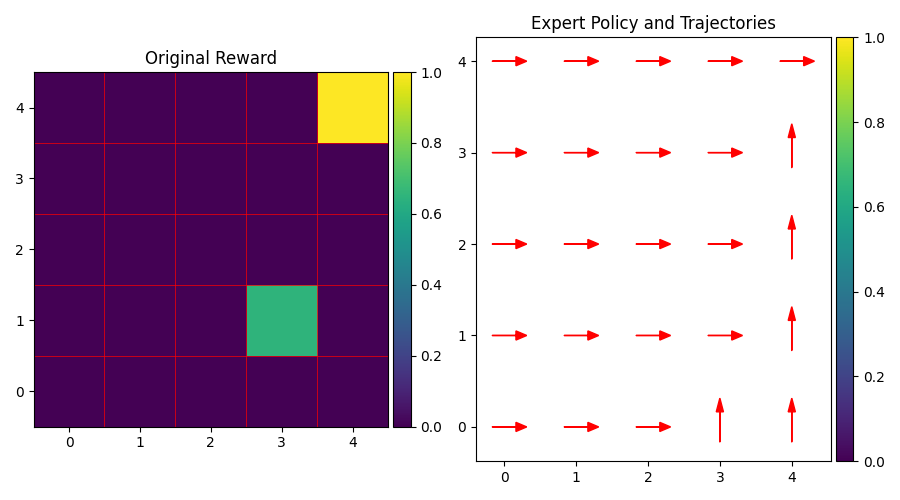

In [131]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.title.set_text('Original Reward')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, reward, **style)
fig.colorbar(p, cax=cax)

ax = fig.add_subplot(122)
ax.title.set_text('Expert Policy and Trajectories')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
P.plot_deterministic_policy(ax, world, expert_policy, color='red')
fig.colorbar(p, cax=cax)

for t in trajectories:
    P.plot_trajectory(ax, world, t, lw=5, color='white', alpha=0.00025)

fig.tight_layout()
plt.show()

In [45]:
def feature_expectation_from_trajectories(features, trajectories):
    n_states, n_features = features.shape

    fe = np.zeros(n_features)

    for t in trajectories:                  # for each trajectory
        for s in t.states():                # for each state in trajectory
            fe += features[s, :]            # sum-up features

    return fe / len(trajectories)           # average over trajectories

In [46]:
def initial_probabilities_from_trajectories(n_states, trajectories):
    p = np.zeros(n_states)

    for t in trajectories:                  # for each trajectory
        p[t.transitions()[0][0]] += 1.0     # increment starting state

    return p / len(trajectories)            # normalize

In [11]:
def compute_expected_svf(p_transition, p_initial, terminal, reward, eps=1e-5):
    n_states, _, n_actions = p_transition.shape
    nonterminal = set(range(n_states)) - set(terminal)  # nonterminal states
    
    # Backward Pass
    # 1. initialize at terminal states
    zs = np.zeros(n_states)                            # zs: state partition function
    zs[terminal] = 1.0

    # 2. perform backward pass
    for _ in range(n_states):                       # longest trajectory: n_states
        # reset action values to zero
        za = np.zeros((n_states, n_actions))            # za: action partition function

        # for each state-action pair
        for s_from, a in product(range(n_states), range(n_actions)):

            # sum over s_to
            for s_to in range(n_states):
                za[s_from, a] += p_transition[s_from, s_to, a] * np.exp(reward[s_from]) * zs[s_to]
        
        # sum over all actions
        zs = za.sum(axis=1)

    # 3. compute local action probabilities
    p_action = za / zs[:, None]

    # Forward Pass
    # 4. initialize with starting probability
    d = np.zeros((n_states, n_states))              # d: state-visitation frequencies
    d[:, 0] = p_initial

    # 5. iterate for N steps
    for t in range(1, n_states):                    # longest trajectory: n_states
        
        # for all states
        for s_to in range(n_states):
            
            # sum over nonterminal state-action pairs
            for s_from, a in product(nonterminal, range(n_actions)):
                d[s_to, t] += d[s_from, t-1] * p_action[s_from, a] * p_transition[s_from, s_to, a]

    # 6. sum-up frequencies
    return d.sum(axis=1)

In [132]:
def maxent_irl(p_transition, features, terminal, trajectories, eps=1e-3):
    n_states, _, n_actions = p_transition.shape
    _, n_features = features.shape

   
    e_features = feature_expectation_from_trajectories(features, trajectories)  # compute feature expectation from trajectories
    
   
    p_initial = initial_probabilities_from_trajectories(n_states, trajectories)  # compute starting-state probabilities from trajectories

    # gradient descent optimization
    omega = np.random.uniform(size=n_features, low=0.0, high=1.0)       # initialize our parameters
    delta = np.inf                  # initialize delta for convergence check             # re-start optimizer
    while delta > eps:              # iterate until convergence
        omega_old = omega.copy()

        # compute per-state reward from features
        reward = features.dot(omega)

        # compute gradient of the log-likelihood
        e_svf = compute_expected_svf(p_transition, p_initial, terminal, reward)
        grad = e_features - features.T.dot(e_svf)

        # perform optimization step and compute delta for convergence
        omega += 0.2 * grad
        # omega *= np.exp(0.2 * grad) # exponential gradient
        # omega/=omega.sum() # normalising weigths
        
        # re-compute detla for convergence check
        delta = np.max(np.abs(omega_old - omega))

    # re-compute per-state reward and return
    return features.dot(omega)

In [ ]:
# set up features: we use one feature vector per state
features = state_features(world)

# choose our parameter initialization strategy:

reward_maxent = maxent_irl(world.p_transition, features, terminal, trajectories)

In [126]:
V_OG, Policy_OG = value_iteration(world, world.p_transition, reward, 0.8)

V_MaxEnt, MaxEnt_Policy = value_iteration(world, world.p_transition, reward_maxent, 0.8)

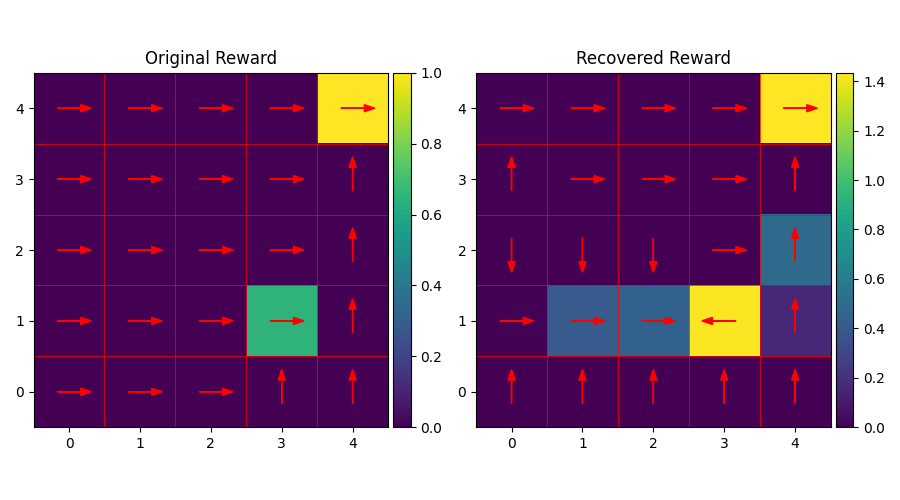

In [127]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.title.set_text('Original Reward')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, reward, **style)
P.plot_deterministic_policy(ax, world, Policy_OG, color='red')
fig.colorbar(p, cax=cax)

ax = fig.add_subplot(122)
ax.title.set_text('Recovered Reward')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, reward_maxent, **style)
P.plot_deterministic_policy(ax, world, MaxEnt_Policy, color='red')
fig.colorbar(p, cax=cax)

fig.tight_layout()
plt.show()
# plt.savefig('MaxEnt_GridWorld_Reward.jpg',dpi=1000,bbox_inches ='tight')

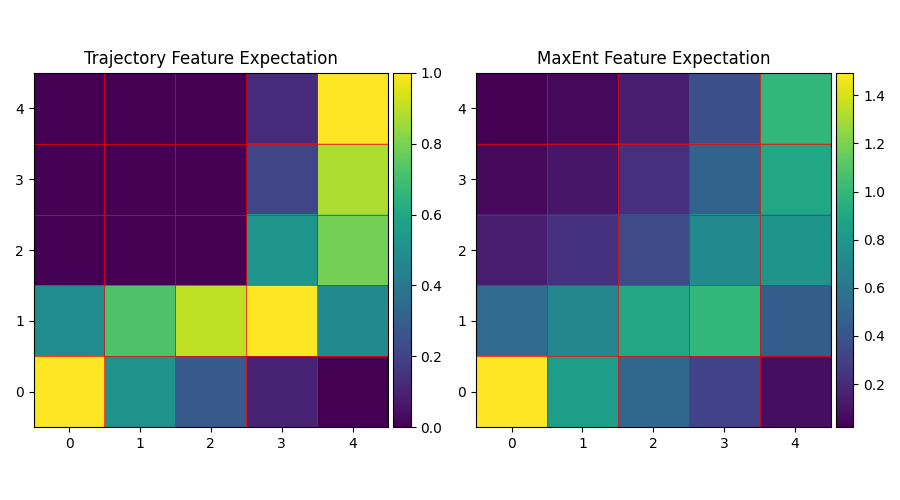

In [112]:
# Note: this code will only work with one feature per state
p_initial = initial_probabilities_from_trajectories(world.n_states, trajectories)
e_svf = compute_expected_svf(world.p_transition, p_initial, terminal, reward_maxent)
e_features = feature_expectation_from_trajectories(features, trajectories)

fig = plt.figure()
ax = fig.add_subplot(121)
ax.title.set_text('Trajectory Feature Expectation')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, e_features, **style)
fig.colorbar(p, cax=cax)

ax = fig.add_subplot(122)
ax.title.set_text('MaxEnt Feature Expectation')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, features.T.dot(e_svf), **style)
fig.colorbar(p, cax=cax)

fig.tight_layout()
plt.show()
# plt.savefig('MaxEnt_Gridworld_feature.jpg',dpi=1000,bbox_inches ='tight')